# [HackerEarth Machine Learning Challenge - Exhibit A(rt)](https://www.hackerearth.com/ja/challenges/competitive/hackerearth-machine-learning-challenge-predict-shipping-cost/machine-learning/predict-the-cost-to-ship-the-sculptures-12-e7728f5d/)
## Predicting the Cost to ship the sculpture

In [305]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [306]:
cd 'drive/My Drive/Colab Notebooks/HE_ML'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/HE_ML'
/content/drive/My Drive/Colab Notebooks/HE_ML


Importing Libraries

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
sub = pd.DataFrame(test['Customer Id'])

In [ ]:
sub.head()

,Customer Id
0,fffe3400310033003300
1,fffe3600350035003400
2,fffe3700360030003500
3,fffe350038003600
4,fffe3500390032003500


Exploring dataset


In [ ]:
df = train
df.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23


In [ ]:
df.shape

(6500, 20)

In [ ]:
df.drop(['Customer Id', 'Artist Name'], axis = 1, inplace = True)
df.shape

(6500, 18)

In [ ]:
test.drop(['Customer Id', 'Artist Name'], axis = 1, inplace = True)
test.shape

(3500, 17)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Artist Reputation      5750 non-null   float64
 1   Height                 6125 non-null   float64
 2   Width                  5916 non-null   float64
 3   Weight                 5913 non-null   float64
 4   Material               5736 non-null   object 
 5   Price Of Sculpture     6500 non-null   float64
 6   Base Shipping Price    6500 non-null   float64
 7   International          6500 non-null   object 
 8   Express Shipment       6500 non-null   object 
 9   Installation Included  6500 non-null   object 
 10  Transport              5108 non-null   object 
 11  Fragile                6500 non-null   object 
 12  Customer Information   6500 non-null   object 
 13  Remote Location        5729 non-null   object 
 14  Scheduled Date         6500 non-null   object 
 15  Deli

Explanatory data analysis

In [ ]:
num_f = df.select_dtypes(include = [np.number])
cat_f = df.select_dtypes(include = [np.object])

In [ ]:
cat_f.head()

,Material,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location
0,Brass,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777"
1,Brass,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072"
2,Clay,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241"
3,Aluminium,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375"
4,Aluminium,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793"


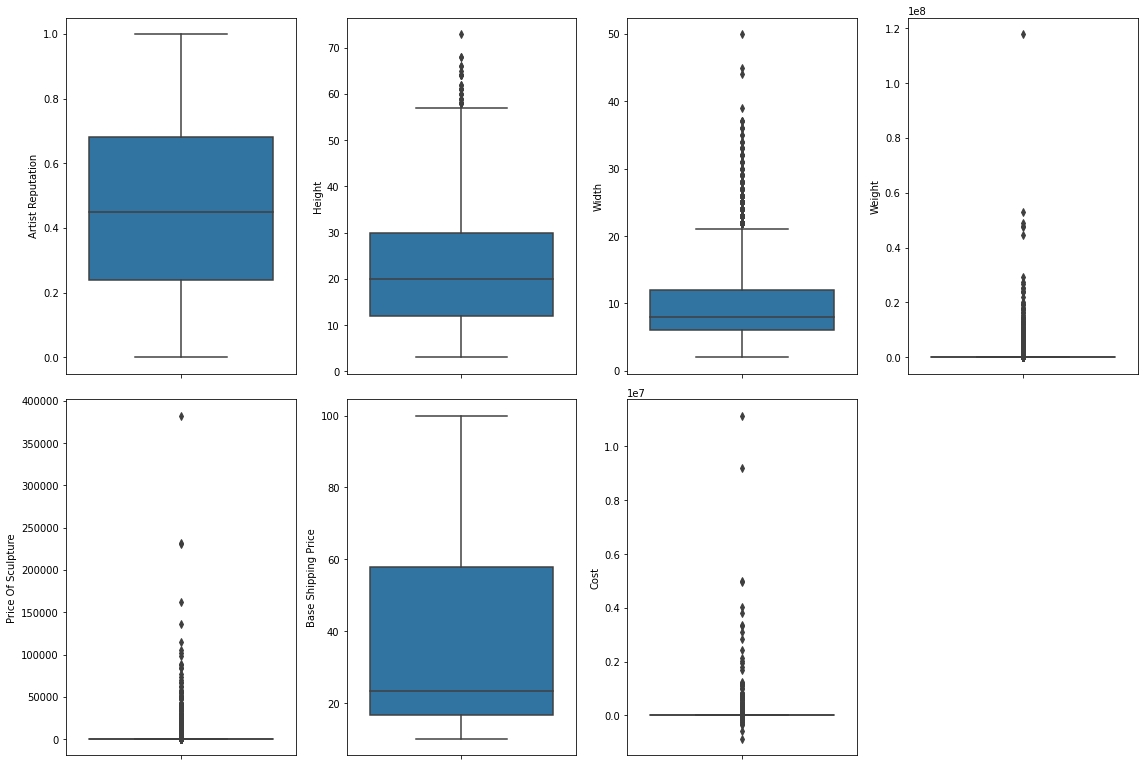

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(len(num_f.columns)):
    fig.add_subplot(3, 4, i+1)
    sns.boxplot(y=num_f.iloc[:,i])
plt.tight_layout()
plt.show()

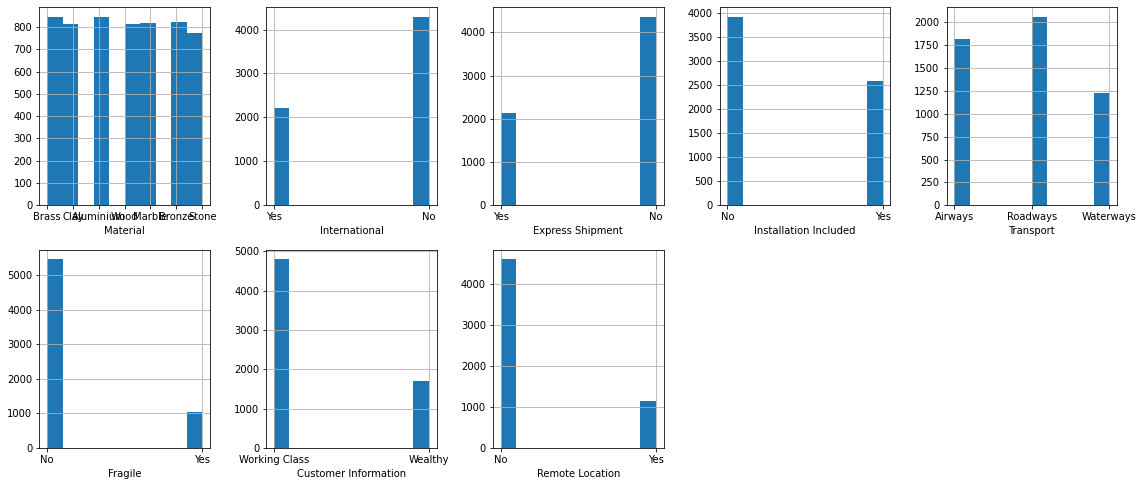

In [ ]:
fig = plt.figure(figsize=(16,30))
for i in range(len(cat_f.columns[:-3])):
    fig.add_subplot(9, 5, i+1)
    cat_f.iloc[:,i].hist()
    plt.xlabel(cat_f.columns[i])
plt.tight_layout()
plt.show()

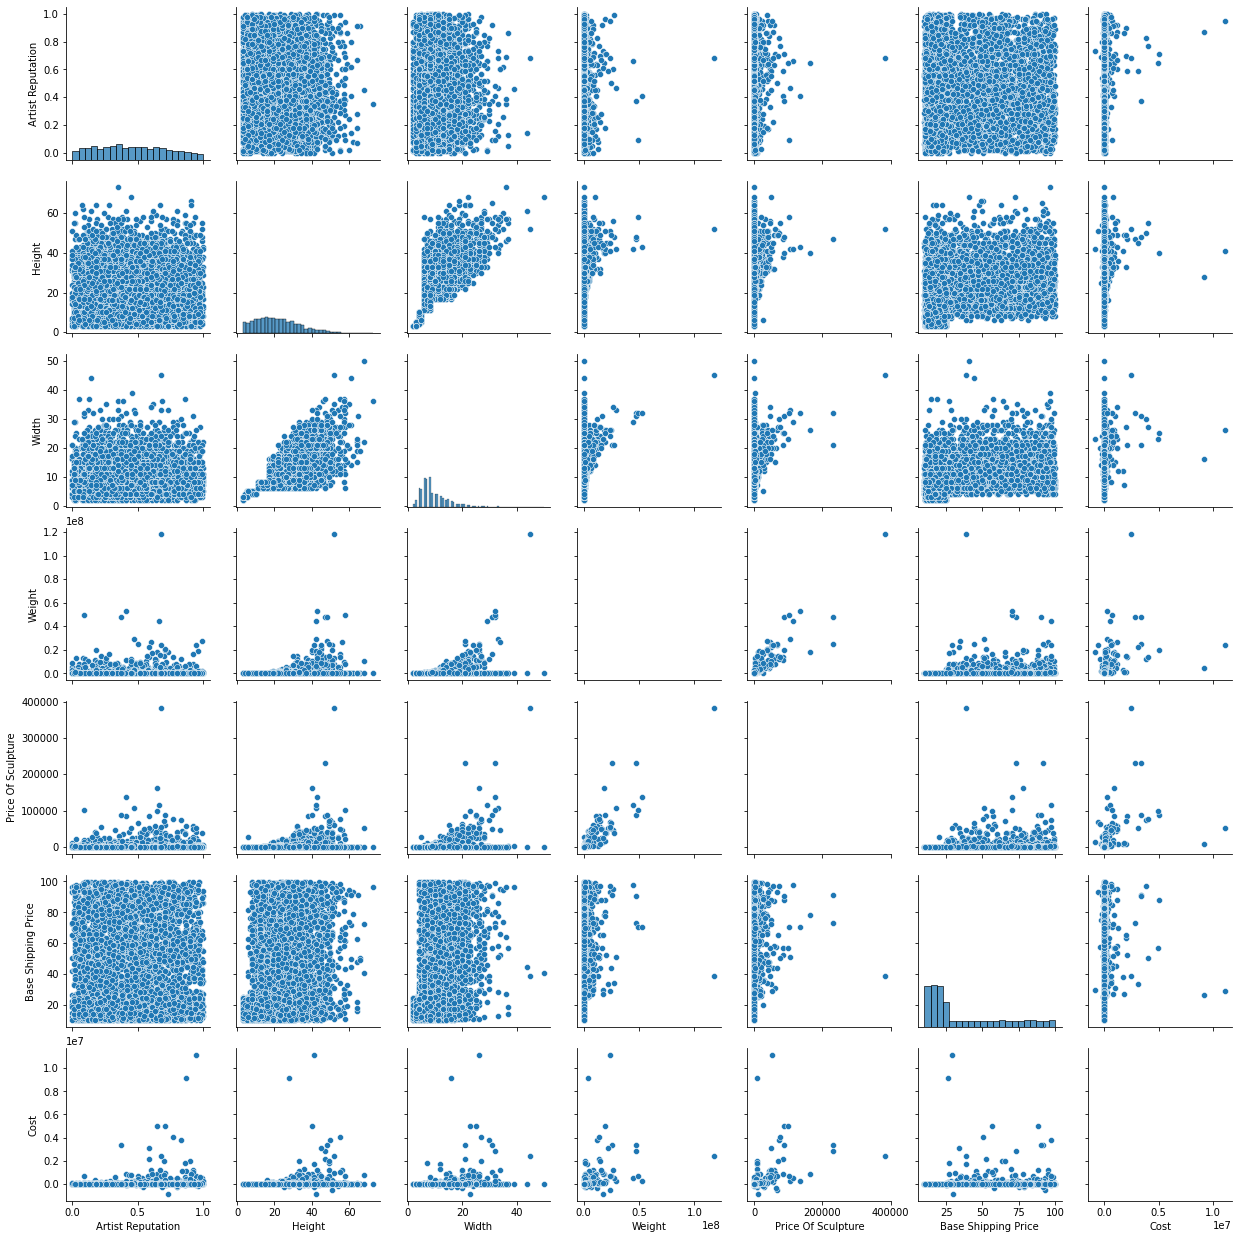

In [ ]:
sns.pairplot(df)
plt.show()

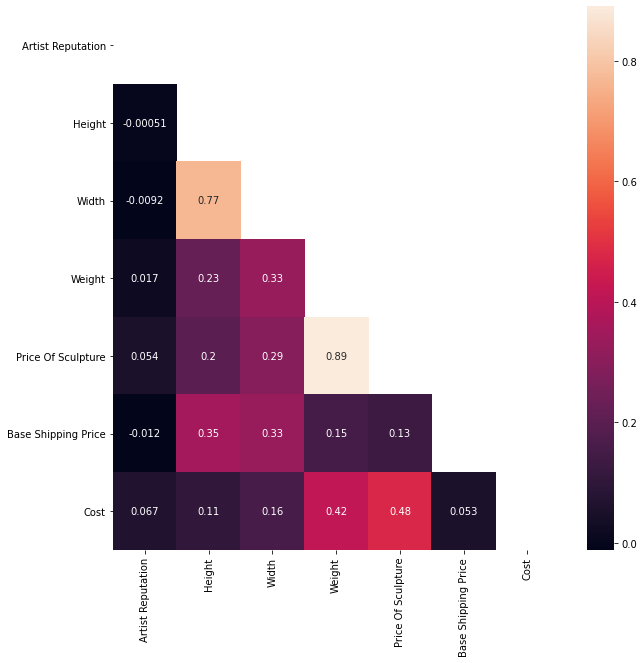

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot=True)
plt.show()

## Preprocessing Dataset


In [ ]:
df.describe()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,Cost
count,5750.000000,6125.000000,5916.000000,5.913000e+03,6500.00000,6500.000000,6.500000e+03
mean,0.461850,21.766204,9.617647,4.006948e+05,1192.42009,37.407174,1.713920e+04
std,0.265781,11.968192,5.417000,2.678081e+06,8819.61675,26.873519,2.406579e+05
min,0.000000,3.000000,2.000000,3.000000e+00,3.00000,10.000000,-8.801727e+05
25%,0.240000,12.000000,6.000000,5.030000e+02,5.23000,16.700000,1.884400e+02
50%,0.450000,20.000000,8.000000,3.102000e+03,8.02500,23.505000,3.820650e+02
75%,0.680000,30.000000,12.000000,3.645600e+04,89.47000,57.905000,1.156115e+03
max,1.000000,73.000000,50.000000,1.179279e+08,382385.67000,99.980000,1.114343e+07


In [ ]:
df.isna().sum()

Artist Reputation         750
Height                    375
Width                     584
Weight                    587
Material                  764
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1392
Fragile                     0
Customer Information        0
Remote Location           771
Scheduled Date              0
Delivery Date               0
Customer Location           0
Cost                        0
dtype: int64

Filling Missing Values

In [ ]:
df['Artist Reputation'].fillna(df['Artist Reputation'].median(),inplace = True)
test['Artist Reputation'].fillna(test['Artist Reputation'].median(),inplace = True)
df['Artist Reputation'].isna().any()

False

In [ ]:
df['Height'].fillna(df['Height'].median(), inplace = True)
test['Height'].fillna(test['Height'].median(), inplace = True)
df['Height'].isna().any()

False

In [ ]:
df['Width'].fillna(df['Width'].median(), inplace = True)
test['Width'].fillna(test['Width'].median(), inplace = True)
df['Width'].isna().any()

False

In [ ]:
df['Weight'].fillna(df['Weight'].median(), inplace = True)
test['Weight'].fillna(test['Weight'].median(), inplace = True)
df['Weight'].isna().any()

False

In [ ]:
df['Transport'].fillna(df['Transport'].mode()[0], inplace = True)
test['Transport'].fillna(test['Transport'].mode()[0], inplace = True)
df['Transport'].isna().any()

False

In [ ]:
df['Remote Location'].fillna(df['Remote Location'].mode()[0], inplace = True)
test['Remote Location'].fillna(test['Remote Location'].mode()[0], inplace = True)
df['Remote Location'].isna().any()

False

In [ ]:
df['Material'].fillna(df['Material'].mode()[0], inplace = True)
test['Material'].fillna(test['Material'].mode()[0], inplace = True)
df['Material'].isna().any()

False

In [ ]:
df.isna().any().sum()

0

In [ ]:
test.isna().any().sum()

0

Deriving features


In [ ]:
df['state'] = df['Customer Location'].map(lambda x:x.split()[-2])
df.drop('Customer Location', inplace=True, axis=1)

In [ ]:
test['state'] = test['Customer Location'].map(lambda x:x.split()[-2])
test.drop('Customer Location', inplace=True, axis=1)
test.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,state
0,0.35,53.0,18.0,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,07/03/17,07/06/17,IA
1,0.67,7.0,4.0,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,05/02/16,05/02/16,OH
2,0.61,6.0,5.0,97.0,Aluminium,4.23,13.62,Yes,No,No,Airways,No,Working Class,No,01/04/18,01/06/18,AP
3,0.14,15.0,8.0,757.0,Clay,6.28,23.79,No,Yes,No,Roadways,Yes,Wealthy,No,09/14/17,09/17/17,AL
4,0.63,10.0,4.0,1673.0,Marble,4.39,17.83,No,Yes,Yes,Roadways,No,Working Class,Yes,12/03/17,12/02/17,LA


In [ ]:
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])
df['scheduleDiff'] = (df['Delivery Date'] - df['Scheduled Date']).map(lambda x:str(x).split()[0])
df['scheduleDiff'] = pd.to_numeric(df['scheduleDiff'])

In [ ]:
test['Scheduled Date'] = pd.to_datetime(test['Scheduled Date'])
test['Delivery Date'] = pd.to_datetime(test['Delivery Date'])
test['scheduleDiff'] = (test['Delivery Date'] - test['Scheduled Date']).map(lambda x:str(x).split()[0])
test['scheduleDiff'] = pd.to_numeric(test['scheduleDiff'])

test.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,state,scheduleDiff
0,0.35,53.0,18.0,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,2017-07-03,2017-07-06,IA,3
1,0.67,7.0,4.0,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,2016-05-02,2016-05-02,OH,0
2,0.61,6.0,5.0,97.0,Aluminium,4.23,13.62,Yes,No,No,Airways,No,Working Class,No,2018-01-04,2018-01-06,AP,2
3,0.14,15.0,8.0,757.0,Clay,6.28,23.79,No,Yes,No,Roadways,Yes,Wealthy,No,2017-09-14,2017-09-17,AL,3
4,0.63,10.0,4.0,1673.0,Marble,4.39,17.83,No,Yes,Yes,Roadways,No,Working Class,Yes,2017-12-03,2017-12-02,LA,-1


In [ ]:
df['dday'] = df['Delivery Date'].dt.day
df['dmonth'] = df['Delivery Date'].dt.month
df['dyear'] = df['Delivery Date'].dt.year
df['ddayofweek'] = df['Delivery Date'].dt.dayofweek

In [ ]:
test['dday'] = test['Delivery Date'].dt.day
test['dmonth'] = test['Delivery Date'].dt.month
test['dyear'] = test['Delivery Date'].dt.year
test['ddayofweek'] = test['Delivery Date'].dt.dayofweek

test.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
0,0.35,53.0,18.0,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,2017-07-03,2017-07-06,IA,3,6,7,2017,3
1,0.67,7.0,4.0,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,2016-05-02,2016-05-02,OH,0,2,5,2016,0
2,0.61,6.0,5.0,97.0,Aluminium,4.23,13.62,Yes,No,No,Airways,No,Working Class,No,2018-01-04,2018-01-06,AP,2,6,1,2018,5
3,0.14,15.0,8.0,757.0,Clay,6.28,23.79,No,Yes,No,Roadways,Yes,Wealthy,No,2017-09-14,2017-09-17,AL,3,17,9,2017,6
4,0.63,10.0,4.0,1673.0,Marble,4.39,17.83,No,Yes,Yes,Roadways,No,Working Class,Yes,2017-12-03,2017-12-02,LA,-1,2,12,2017,5


In [ ]:
df.drop(['Delivery Date', 'Scheduled Date'], inplace=True, axis=1)
df.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Cost,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
0,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,-283.29,OH,-4,3,6,2015,2
1,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,-159.96,WY,-1,5,3,2017,6
2,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,-154.29,WA,-1,8,3,2015,6
3,0.12,9.0,8.0,3102.0,Aluminium,5.81,16.31,No,No,No,Roadways,No,Wealthy,Yes,-161.16,KY,-4,20,5,2015,2
4,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,-159.23,PA,-4,14,12,2016,2


In [ ]:
test.drop(['Delivery Date', 'Scheduled Date'], inplace=True, axis=1)
test.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
0,0.35,53.0,18.0,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,IA,3,6,7,2017,3
1,0.67,7.0,4.0,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,OH,0,2,5,2016,0
2,0.61,6.0,5.0,97.0,Aluminium,4.23,13.62,Yes,No,No,Airways,No,Working Class,No,AP,2,6,1,2018,5
3,0.14,15.0,8.0,757.0,Clay,6.28,23.79,No,Yes,No,Roadways,Yes,Wealthy,No,AL,3,17,9,2017,6
4,0.63,10.0,4.0,1673.0,Marble,4.39,17.83,No,Yes,Yes,Roadways,No,Working Class,Yes,LA,-1,2,12,2017,5


Encoding categorical variable to numeric


In [ ]:
num_f = df.select_dtypes(include = [np.number])
cat_f = df.select_dtypes(include = [np.object])
num_f1 = test.select_dtypes(include = [np.number])
cat_f2 = test.select_dtypes(include = [np.object])

In [ ]:
enc = LabelEncoder()

In [ ]:
for i in cat_f:
  df[i] = enc.fit_transform(cat_f[i])
  test[i] = enc.fit_transform(cat_f2[i])

In [ ]:
df.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Cost,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
0,0.26,17.0,6.0,4128.0,1,13.91,16.27,1,1,0,0,0,1,0,-283.29,38,-4,3,6,2015,2
1,0.28,3.0,3.0,61.0,1,6.83,15.00,0,0,0,1,0,1,0,-159.96,53,-1,5,3,2017,6
2,0.07,8.0,5.0,237.0,3,4.96,21.18,0,0,0,1,1,1,1,-154.29,50,-1,8,3,2015,6
3,0.12,9.0,8.0,3102.0,0,5.81,16.31,0,0,0,1,0,0,1,-161.16,20,-4,20,5,2015,2
4,0.15,17.0,6.0,324.0,0,3.18,11.94,1,1,1,0,0,1,0,-159.23,41,-4,14,12,2016,2


In [ ]:
test.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
0,0.35,53.0,18.0,871.0,6,5.98,19.11,1,1,0,0,0,1,0,15,3,6,7,2017,3
1,0.67,7.0,4.0,108.0,3,6.92,13.96,0,0,0,1,1,1,0,38,0,2,5,2016,0
2,0.61,6.0,5.0,97.0,0,4.23,13.62,1,0,0,0,0,1,0,4,2,6,1,2018,5
3,0.14,15.0,8.0,757.0,3,6.28,23.79,0,1,0,1,1,0,0,3,3,17,9,2017,6
4,0.63,10.0,4.0,1673.0,4,4.39,17.83,0,1,1,1,0,1,1,21,-1,2,12,2017,5


In [ ]:
df['Cost1'] = np.log1p(abs(df['Cost']))
df.drop(['Cost'],axis=1,inplace=True)
df.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,state,scheduleDiff,dday,dmonth,dyear,ddayofweek,Cost1
0,0.26,17.0,6.0,4128.0,1,13.91,16.27,1,1,0,0,0,1,0,38,-4,3,6,2015,2,5.649995
1,0.28,3.0,3.0,61.0,1,6.83,15.00,0,0,0,1,0,1,0,53,-1,5,3,2017,6,5.081156
2,0.07,8.0,5.0,237.0,3,4.96,21.18,0,0,0,1,1,1,1,50,-1,8,3,2015,6,5.045294
3,0.12,9.0,8.0,3102.0,0,5.81,16.31,0,0,0,1,0,0,1,20,-4,20,5,2015,2,5.088584
4,0.15,17.0,6.0,324.0,0,3.18,11.94,1,1,1,0,0,1,0,41,-4,14,12,2016,2,5.076610


### Modelling

Splitting our data into train and test 

In [ ]:
X = df.drop(['Cost1'], axis=1)
y = df['Cost1']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [ ]:
X_train.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
889,0.00,4.0,4.0,51.0,3,4.70,19.42,0,0,1,0,1,1,0,3,2,3,6,2017,5
4385,0.62,31.0,7.0,2729.0,3,9.20,19.05,0,0,0,1,1,1,0,30,0,27,4,2016,2
4919,0.37,18.0,9.0,233674.0,5,1011.11,90.95,0,1,0,1,0,0,0,5,-4,8,10,2015,3
4794,0.49,7.0,8.0,5046.0,5,10.31,70.65,0,1,1,1,0,0,0,16,3,27,1,2019,6
5438,0.40,26.0,10.0,15590.0,1,22.03,57.78,0,0,0,0,0,1,0,53,0,16,7,2018,0


In [ ]:
y_val

3106    6.127109
6161    5.244283
1867    5.982928
3238    6.510303
5509    5.900664
          ...   
1770    5.126342
1608    7.396979
2191    6.528177
624     6.633318
69      7.054622
Name: Cost1, Length: 1300, dtype: float64

### Random Forest 

In [ ]:
regressor = RandomForestRegressor(criterion='mse', random_state=123, max_depth=10, n_estimators=1000,min_samples_leaf=4, min_samples_split=2)

In [ ]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [ ]:
y_tr = regressor.predict(X_train)
y_te = regressor.predict(X_val)
rms1 = mean_squared_error(y_train, y_tr, squared=False)
rms2 = mean_squared_error(y_val, y_te, squared=False)
print("RMSE of train:",rms1,"\nRMSE of test:",rms2)

RMSE of train: 0.22442710263507787 
RMSE of test: 0.34761455147039566


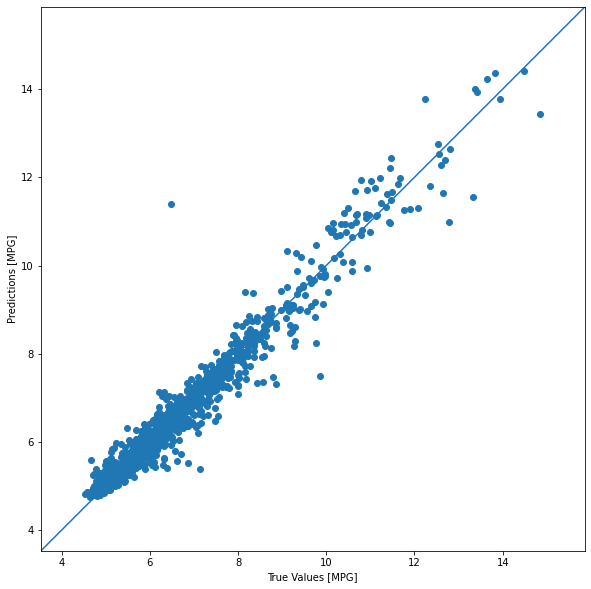

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_val, y_te, label='Actual')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [min(y_val)-1, max(y_val)+1]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, label='Predicted')

In [ ]:
actual = np.expm1(y_val)
predicted = np.expm1(y_te)
score = 100*max(0, 1-metrics.mean_squared_log_error(actual, predicted))
score

87.91641236060357

### XGBoost 

In [ ]:
xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [0.01, 0.02], 
              'max_depth': [5, 8],
              'colsample_bytree': [0.3,0.7],
              'n_estimators': [500, 1000],
              'tree_method':['gpu_hist']}

In [ ]:
xgb_cv = RandomizedSearchCV(xgb1, parameters, cv = 3, verbose=True)

In [ ]:
xgb_cv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[08:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[08:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.4min finished


[08:04:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_job

In [ ]:
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)

0.9627369236079941
{'tree_method': 'gpu_hist', 'objective': 'reg:linear', 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.7}


In [ ]:
y_tr = xgb_cv.best_estimator_.predict(X_train)
y_te = xgb_cv.best_estimator_.predict(X_val)

In [ ]:
rms1 = mean_squared_error(y_train, y_tr, squared=False)
rms2 = mean_squared_error(y_val, y_te, squared=False)
print("RMSE of train:",rms1,"\nRMSE of test:",rms2)

RMSE of train: 0.1586849060283356 
RMSE of test: 0.2875342650911448


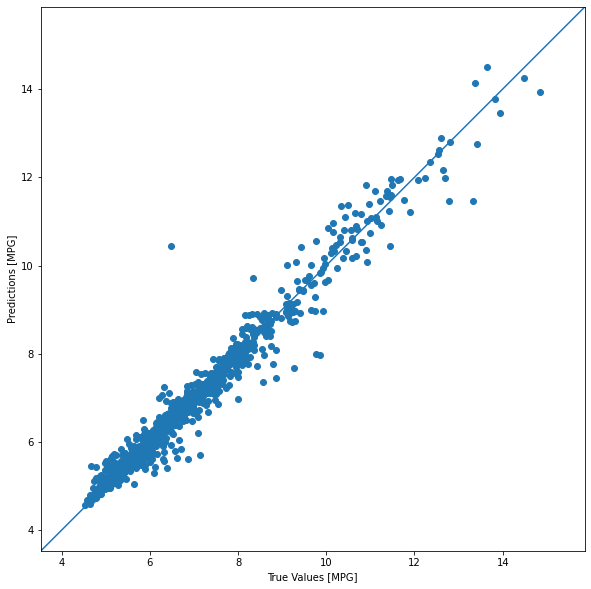

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_val, y_te, label='Actual')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [min(y_val)-1, max(y_val)+1]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, label='Predicted')

In [ ]:
actual = np.expm1(y_val)
predicted = np.expm1(y_te)
score = 100*max(0, 1-metrics.mean_squared_log_error(actual, predicted))
score

91.73240463984953

### ANN

In [ ]:
scaler = MinMaxScaler()
X_train1 = pd.DataFrame(scaler.fit_transform(X_train))
X_val1 = pd.DataFrame(scaler.fit_transform(X_val))
X_train.describe()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
count,5200.000000,5200.000000,5200.000000,5.200000e+03,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000
mean,0.460362,21.751346,9.474038,3.614161e+05,2.729231,1159.213617,37.627388,0.339038,0.335385,0.395577,0.909231,0.160385,0.731154,0.175577,25.024808,-0.053077,15.519038,6.216346,2016.837692,2.993654
std,0.249721,11.718877,5.192218,2.587106e+06,1.983426,8644.538655,26.974182,0.473428,0.472170,0.489021,0.677611,0.366998,0.443402,0.380496,16.174787,2.443017,8.774823,3.381313,1.350558,1.995127
min,0.000000,3.000000,2.000000,3.000000e+00,0.000000,3.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,1.000000,1.000000,2015.000000,0.000000
25%,0.270000,13.000000,6.000000,5.910000e+02,1.000000,5.277500,16.747500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,-2.000000,8.000000,3.000000,2016.000000,1.000000
50%,0.450000,20.000000,8.000000,3.102000e+03,2.000000,8.185000,23.520000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,25.000000,0.000000,15.000000,6.000000,2017.000000,3.000000
75%,0.640000,29.000000,11.000000,2.667525e+04,4.000000,91.772500,58.440000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,39.000000,2.000000,23.000000,9.000000,2018.000000,5.000000
max,1.000000,73.000000,50.000000,1.179279e+08,6.000000,382385.670000,99.980000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,53.000000,4.000000,31.000000,12.000000,2019.000000,6.000000


In [ ]:
model = Sequential()
model.add(Dense(2048, input_dim=20, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 2048)              43008     
_________________________________________________________________
dropout_48 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_49 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)             

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [ ]:
history = model.fit(X_train1, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/150
84/84 [==============================] - 1s 5ms/step - loss: 9.1352 - mse: 9.1352 - mae: 2.1969 - val_loss: 1.1441 - val_mse: 1.1441 - val_mae: 0.7836
Epoch 2/150
84/84 [==============================] - 0s 3ms/step - loss: 1.7626 - mse: 1.7626 - mae: 0.9825 - val_loss: 1.5253 - val_mse: 1.5253 - val_mae: 0.8440
Epoch 3/150
84/84 [==============================] - 0s 3ms/step - loss: 1.6223 - mse: 1.6223 - mae: 0.9321 - val_loss: 1.2139 - val_mse: 1.2139 - val_mae: 0.7248
Epoch 4/150
84/84 [==============================] - 0s 4ms/step - loss: 1.4517 - mse: 1.4517 - mae: 0.8850 - val_loss: 1.0454 - val_mse: 1.0454 - val_mae: 0.6677
Epoch 5/150
84/84 [==============================] - 0s 4ms/step - loss: 1.4028 - mse: 1.4028 - mae: 0.8762 - val_loss: 0.8506 - val_mse: 0.8506 - val_mae: 0.6424
Epoch 6/150
84/84 [==============================] - 0s 3ms/step - loss: 1.4402 - mse: 1.4402 - mae: 0.8910 - val_loss: 0.7205 - val_mse: 0.7205 - val_mae: 0.5665
Epoch 7/150
84/84 [===

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


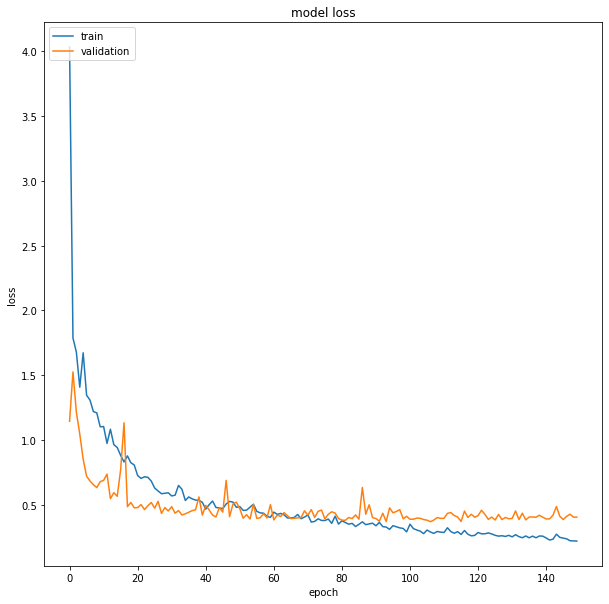

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_tr = model.predict(X_train1)
y_te = model.predict(X_val1)

In [ ]:
rms1 = mean_squared_error(y_train, y_tr, squared=False)
rms2 = mean_squared_error(y_val, y_te, squared=False)
print("RMSE of train:",rms1,"\nRMSE of test:",rms2)

RMSE of train: 0.40125136479410756 
RMSE of test: 0.7500976013690528


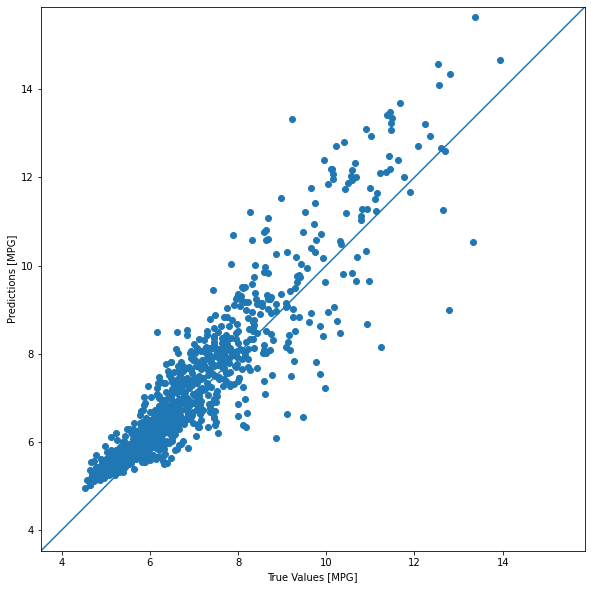

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_val, y_te, label='Actual')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [min(y_val)-1, max(y_val)+1]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, label='Predicted')

In [ ]:
actual = np.expm1(y_val)
predicted = np.expm1(y_te)
score = 100*max(0, 1-metrics.mean_squared_log_error(actual, predicted))
score

43.73535884203935

### Working on train and test model

In [ ]:
X = train.drop(['Cost1'], axis=1)
X.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,state,scheduleDiff,dday,dmonth,dyear,ddayofweek
0,0.26,17.0,6.0,4128.0,1,13.91,16.27,1,1,0,0,0,1,0,38,-4,3,6,2015,2
1,0.28,3.0,3.0,61.0,1,6.83,15.00,0,0,0,1,0,1,0,53,-1,5,3,2017,6
2,0.07,8.0,5.0,237.0,3,4.96,21.18,0,0,0,1,1,1,1,50,-1,8,3,2015,6
3,0.12,9.0,8.0,3102.0,0,5.81,16.31,0,0,0,1,0,0,1,20,-4,20,5,2015,2
4,0.15,17.0,6.0,324.0,0,3.18,11.94,1,1,1,0,0,1,0,41,-4,14,12,2016,2


In [ ]:
y = train['Cost1']
y

0       5.649995
1       5.081156
2       5.045294
3       5.088584
4       5.076610
          ...   
6495    6.772428
6496    7.206392
6497    5.873666
6498    8.524864
6499    6.584059
Name: Cost1, Length: 6500, dtype: float64

### XGB

In [ ]:
xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [0.01, 0.02], 
              'max_depth': [5, 8],
              'colsample_bytree': [0.3, 0.7],
              'n_estimators': [500, 1000],
              'tree_method':['gpu_hist']}

In [ ]:
xgb_cv = RandomizedSearchCV(xgb1, parameters, cv = 3, verbose=True)

In [ ]:
xgb_cv.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[08:15:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[08:15:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


[08:17:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_job

In [ ]:
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)

0.9657724424646457
{'tree_method': 'gpu_hist', 'objective': 'reg:linear', 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.7}


In [ ]:
y_pred = xgb_cv.best_estimator_.predict(X)
y_pred

array([5.5815983, 5.09252  , 5.097239 , ..., 5.92149  , 8.706804 ,
       6.557694 ], dtype=float32)

In [ ]:
actual = np.expm1(y)
predicted = np.expm1(y_pred)
score = 100*max(0, 1-metrics.mean_squared_log_error(actual, predicted))
score

97.06179614810762

In [ ]:
pred1 = xgb_cv.best_estimator_.predict(test)
pred1 = np.expm1(pred1)
pred1

array([  261.19537,   246.24748,   198.11469, ...,   633.015  ,
         258.66714, 99276.13   ], dtype=float32)

### Random Forest

In [ ]:
regressor = RandomForestRegressor(criterion='mse', random_state=123, max_depth=10, n_estimators=1000,min_samples_leaf=4, min_samples_split=2)
regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [ ]:
y_pred = regressor.predict(X)

In [ ]:
actual = np.expm1(y)
predicted = np.expm1(y_pred)
score = 100*max(0, 1-metrics.mean_squared_log_error(actual, predicted))
score

94.90074397292294

In [ ]:
pred2 = regressor.predict(test)
pred2 = np.expm1(pred2)
pred2

array([   220.76167461,    294.14663062,    222.34636127, ...,
          490.05106291,    254.50146038, 185994.03173499])

**Creating and writing submission File**

In [308]:
sub1 = sub
sub1['Cost'] = pred1
sub1.to_csv("submit4.csv", index = False)
sub1.head()

,Customer Id,Cost
0,fffe3400310033003300,261.195374
1,fffe3600350035003400,246.247482
2,fffe3700360030003500,198.114685
3,fffe350038003600,197.806351
4,fffe3500390032003500,331.752594


In [309]:
sub2 = sub
sub2['Cost'] = pred2
sub2.to_csv("submit5.csv", index = False)
sub2.head()

,Customer Id,Cost
0,fffe3400310033003300,220.761675
1,fffe3600350035003400,294.146631
2,fffe3700360030003500,222.346361
3,fffe350038003600,187.031582
4,fffe3500390032003500,298.631581


In [310]:
pred3 = (pred1+pred2)/2
sub3 = sub
sub3['Cost'] = pred3
sub3.to_csv("submit6.csv", index = False)
sub3.head()

,Customer Id,Cost
0,fffe3400310033003300,240.978524
1,fffe3600350035003400,270.197056
2,fffe3700360030003500,210.230523
3,fffe350038003600,192.418966
4,fffe3500390032003500,315.192088
